In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint, solve_ivp



import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits import mplot3d
import random as random
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

[0 1 2 3 4 5 6]


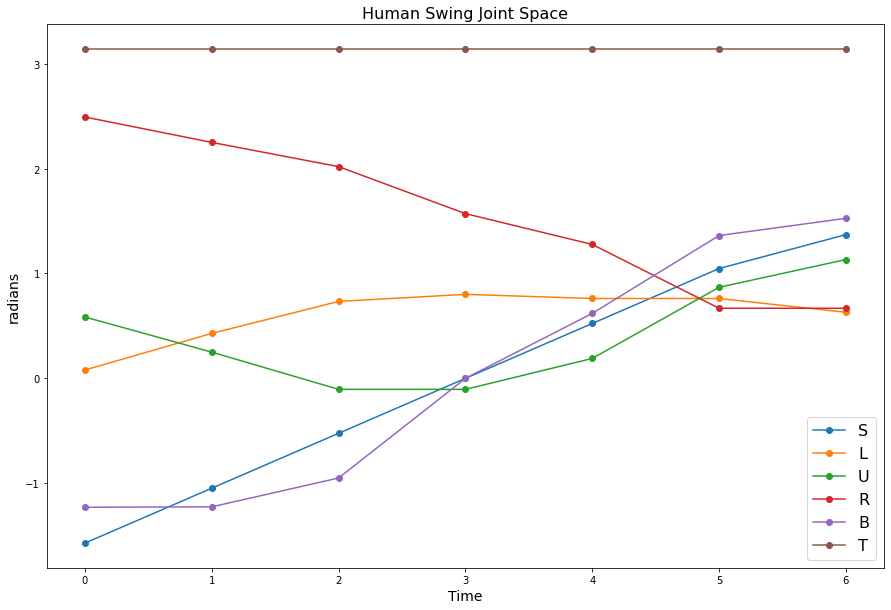

In [3]:
# The SUPER POINTS!!!

index = np.arange(0,7,1)
print(index)
# S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
# L = [.0799,.4289,.7338,.8011,.7616,.7616,.6299]
# U = [.5850,.5085,-.1047,-.1047,.1899,.8684,1.133]
# R = [2.492,2.499,2.019,np.pi/2,1.477,.6686,.6686]
# B = [-1.229,-1.225,-1.246,0,.6196,1.362,1.526]
# T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

# NEW SUPER POINTS
S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2-.2]
L = [.0799,.4289,.7338,.8011,.7617,.7616,.6299]
U = [.5850,.250,-.1047,-.1047,.1899,.8684,1.133]
R = [2.492,2.250,2.019,np.pi/2,1.277,.6686,.6686]
B = [-1.229,-1.225,-.950,0,.6196,1.362,1.526]
T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

#Plot them all
# creating an empty canvas
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(index,S,'-o',index,L,'-o',index,U,'-o',index,R,'-o',index,B,'-o',index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
ax.set_title('Human Swing Joint Space',fontsize = 16)
ax.set_xlabel('Time',fontsize = 14)
ax.set_ylabel('radians',fontsize = 14)
plt.show()

90
[2.492      2.47579464 2.45958929 2.44338393 2.42717857 2.41097321
 2.39476786 2.3785625  2.36235714 2.34615179 2.32994643 2.31374107
 2.29753571 2.28133036 2.265125   2.25       2.23453125 2.2190625
 2.20359375 2.188125   2.17265625 2.1571875  2.14171875 2.12625
 2.11078125 2.0953125  2.07984375 2.064375   2.04890625 2.0334375
 2.019      1.98898636 1.95897272 1.92895908 1.89894544 1.86893181
 1.83891817 1.80890453 1.77889089 1.74887725 1.71886361 1.68884997
 1.65883633 1.6288227  1.59880906 1.57079633 1.55112247 1.5314486
 1.51177474 1.49210088 1.47242702 1.45275316 1.4330793  1.41340544
 1.39373158 1.37405772 1.35438385 1.33470999 1.31503613 1.29536227
 1.277      1.23625893 1.19551786 1.15477679 1.11403571 1.07329464
 1.03255357 0.9918125  0.95107143 0.91033036 0.86958929 0.82884821
 0.78810714 0.74736607 0.706625   0.6686     0.6686     0.6686
 0.6686     0.6686     0.6686     0.6686     0.6686     0.6686
 0.6686     0.6686     0.6686     0.6686     0.6686     0.6686    ]


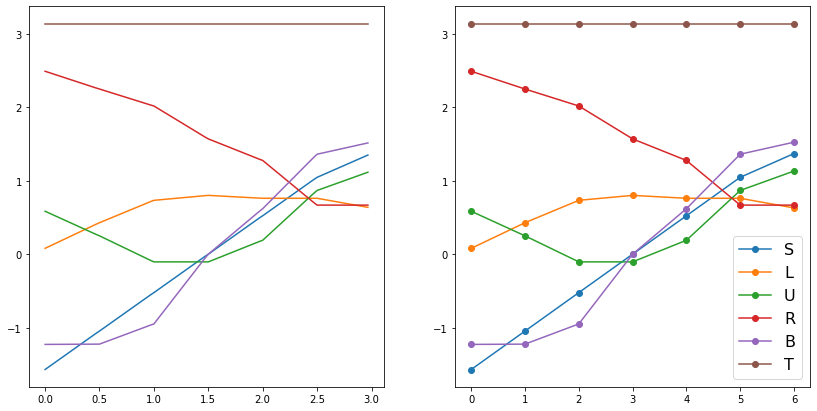

In [4]:
intervals = 16


def Interp(theta,intervals):
    long_theta = [] 
    parts = np.zeros((6,intervals-1))
    for i in range(int(len(theta)-1)):
        delta = (theta[i+1]-theta[i])/intervals
        parts[i] = np.linspace(theta[i],theta[i+1]-delta,intervals-1)
    for j in range(int(len(parts))):
        long_theta = np.append(long_theta,parts[j])
    
    return long_theta

long_S = Interp(S,intervals)
long_L = Interp(L,intervals)
long_U = Interp(U,intervals)
long_R = Interp(R,intervals)
long_B = Interp(B,intervals)
long_T = Interp(T,intervals)
                     
pts = len(long_R)
print(len(long_R))
print(long_R)

t_start = 0
t_end =3
delta_t = t_end/pts
t_pts = np.arange(t_start,t_end,delta_t)

fig2 = plt.figure(figsize = (14,7))
ax2 = fig2.add_subplot(1,2,1)
ax3 = fig2.add_subplot(1,2,2)
ax2.plot(t_pts,long_S,'-')
ax2.plot(t_pts,long_L,'-')
ax2.plot(t_pts,long_U,'-')
ax2.plot(t_pts,long_R,'-')
ax2.plot(t_pts,long_B,'-')
ax2.plot(t_pts,long_T,'-')
ax3.plot(index,S,'-o')
ax3.plot(index,L,'-o')
ax3.plot(index,U,'-o')
ax3.plot(index,R,'-o')
ax3.plot(index,B,'-o')
ax3.plot(index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
plt.show()

In [5]:
#Back to my robot vectors stuff. 

class Robot():
    
    #Class for the robot with lengths of links and the axis defined as they would be in the defalt zero position
    
    def __init__(self, links, axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]):
        self.links = links
        self.axis = axis
        
    def rotateAxis(self, t, vec):
        
        #Rotation matrix just taken straight from wikepedia
        
        C = 1-np.cos(t);
        x,y,z = vec;

        Rot = [[x**2*C+np.cos(t), x*y*C-z*np.sin(t), z*x*C+y*np.sin(t)],
                [x*y*C+z*np.sin(t), y**2*C+np.cos(t), z*y*C-x*np.sin(t)],
                [x*z*C-y*np. sin(t), y*z*C+x*np.sin(t), z**2*C+np.cos(t)]]

        return Rot

    def findEnd(self, angles):
        #This function takes an input vector of angles and will output the end position as
        #well as all of the vectors of the robot NOT TRANSLATED FROM THE ORIGIN
        
        v1 = [0,0,0] #Base thing that moves with S
        v2 = [0,0,0] #First link that moves with L
        v3 = [0,0,0] #Second link that moves with U
        v4 = [0,0,0] #Shaft link that moves with B
        v5 = [0,0,0] #Club head that moves with T/R
        
        #Starting Vector
        v1_0 = [self.links[0]/np.sqrt(2),0,self.links[0]/np.sqrt(2)]
        v5_0 = [self.links[4]/np.sqrt(2),0,self.links[4]/np.sqrt(2)]
        
        #First rotation
        v1 = np.dot(v1_0,self.rotateAxis(angles[0], self.axis[0]))
        axis1 = np.dot(self.axis[1],self.rotateAxis(angles[0], self.axis[0]))
        axis2 = np.dot(self.axis[2],self.rotateAxis(angles[0], self.axis[0]))
        axis3 = np.dot(self.axis[3],self.rotateAxis(angles[0], self.axis[0]))
        axis4 = np.dot(self.axis[4],self.rotateAxis(angles[0], self.axis[0]))
        
        #Second Rotation
        v2 = (self.links[1]/self.links[0])*np.dot(v1,self.rotateAxis(angles[1], axis1))
        axis2 = np.dot(axis2,self.rotateAxis(angles[1], axis1))
        axis3 = np.dot(axis3,self.rotateAxis(angles[1], axis1))
        axis4 = np.dot(axis4,self.rotateAxis(angles[1], axis1))
        
        #Third Rotation
        v3 = (self.links[2]/self.links[1])*np.dot(v2,self.rotateAxis(angles[2], axis2))
        axis3 = np.dot(axis3,self.rotateAxis(angles[2], axis2))
        axis4 = np.dot(axis4,self.rotateAxis(angles[2], axis2))

        #Fourth rotation
        axis3 = np.dot(axis3,self.rotateAxis(angles[3], v3/self.links[2])) #This needs to be a unit vector!!!!
        axis4 = np.dot(axis4,self.rotateAxis(angles[3], v3/self.links[2]))
        
        #Fifth Rotation
        v4 = (self.links[3]/self.links[2])*np.dot(v3,self.rotateAxis(angles[4], axis3))
        axis4 = np.dot(axis4,self.rotateAxis(angles[4], axis3))
        
        #Sixth Rotation
        v5 = np.dot(v5_0,self.rotateAxis(angles[5], axis4))
        
        
        x_val = v1[0]+v2[0]+v3[0]+v4[0]+v5[0]
        y_val = v1[1]+v2[1]+v3[1]+v4[1]+v5[1]
        z_val = v1[2]+v2[2]+v3[2]+v4[2]+v5[2]
        
        return [x_val, y_val, z_val, v1, v2, v3, v4, v5]
    
    def distanceFromTarget(self,targ,angles):
        
        #Simply finds the distance between a given end from a set of angles and a target end point
        
        end = self.findEnd(angles)
        dist = (end[0]-targ[0])**2+(end[1]-targ[1])**2+(end[2]-targ[2])**2
        
        return dist
    



In [6]:
def drawRobot(v1,v2,v3,v4,v5):
    
    #I guess the name of this function is deceptive but it takes the vectors and translates them essentially
    
    x = np.zeros(100,)
    y = np.zeros(100,)
    z = np.zeros(100,)

    # This is an admittedly weird way to do this, but it is what it is.
    # The process is like walking along in the direction of vectors 1-5 until you reach the end
    # The magnitude of the links are arbitrary but the relative size is still normal as defined
    
    for i in range(100):
        if i <= 19:
            x[i] = i*v1[0]
            y[i] = i*v1[1]
            z[i] = i*v1[2]
        elif i > 19 and i<=39:
            x[i] = 19*v1[0] + (i-19)*v2[0]
            y[i] = 19*v1[1] + (i-19)*v2[1]
            z[i] = 19*v1[2] + (i-19)*v2[2]
        elif i > 39 and i<=59:
            x[i] = 19*v1[0] + 20*v2[0]+ (i-39)*v3[0]
            y[i] = 19*v1[1] + 20*v2[1]+ (i-39)*v3[1]
            z[i] = 19*v1[2] + 20*v2[2]+ (i-39)*v3[2]
        elif i > 59 and i<=79:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + (i-59)*v4[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + (i-59)*v4[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + (i-59)*v4[2]
        else:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + 20*v4[0] + (i-79)*v5[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + 20*v4[1] + (i-79)*v5[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + 20*v4[2] + (i-79)*v5[2]
    
    return x,y,z

In [7]:
def drawRobot2(v1,v2,v3,v4,v5):
    
    x = np.zeros(6,)
    y = np.zeros(6,)
    z = np.zeros(6,)
    
    x[0],y[0],z[0] = [0,0,0]
    x[1],y[1],z[1] = v1
    x[2],y[2],z[2] = v1+v2
    x[3],y[3],z[3] = v1+v2+v3
    x[4],y[4],z[4] = v1+v2+v3+v4
    x[5],y[5],z[5] = v1+v2+v3+v4+v5
    
    print(x)
    print(y)
    print(z)
    
    return x,y,z

[48.329734006630005, -24.395183950935884, -15.82749891406172]
[ 0.          3.86363145 18.92265051 31.86231991 46.91552044 48.32973401]
[  0.           0.           0.           0.         -24.39518395
 -24.39518395]
[  0.           3.86363145  18.45701506   1.95532254 -17.24171248
 -15.82749891]


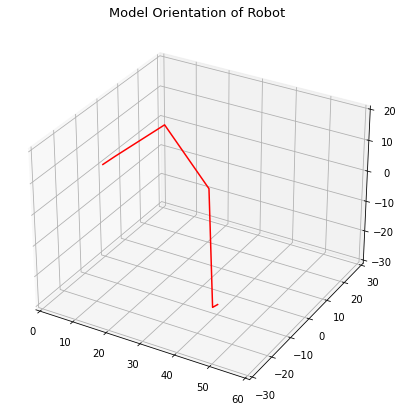

In [8]:
# Make a real robot 

real_links = np.array([5.464,20.97,20.97,34.5,2])
links = real_links*(1/20)
#print(links)
axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]


#anglesDesired = [np.pi/4,0,0,np.pi/2,np.pi/2,0]
anglesDesired = [S[3],L[3],U[3],R[3],B[3]-np.pi/4,T[3]]
#anglesDesired = [0,.5,.5,10,1,10]

#Changing from normal physics conventions of angle definition to the way the robot defines them:
anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                    (-np.pi/2+anglesDesired[2]),anglesDesired[3],anglesDesired[4],np.pi-anglesDesired[5]]

Moto = Robot(links = real_links, axis = axis)
End = Moto.findEnd(anglesConvention)
print([End[0],End[1],End[2]])

#Show on a 3D plot

v1,v2,v3,v4,v5 = End[3],End[4],End[5],End[6],End[7]

x,y,z = drawRobot2(v1,v2,v3,v4,v5)
             
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig = plt.figure(figsize = (7,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
ax.set_xlim(0,60)
ax.set_ylim(-30,30)
ax.set_zlim(-30,20)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax.plot3D(x,y,z, 'red')


 
# Showing the above plot
plt.title('Model Orientation of Robot',fontsize=13)
plt.show()

In [9]:
# Look at the end of the robot as it goes through this swing, then try to say something about the velcoity of the club head

x_end = np.zeros(pts,)
y_end = np.zeros(pts,)
z_end = np.zeros(pts,)
dist = np.zeros(pts-1,)

for i in range(pts):
    
    anglesDesired = [long_S[i],long_L[i],long_U[i],long_R[i],long_B[i],long_T[i]]
    #Changing from normal physics conventions of angle definition to the way the robot defines them:
    anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                        (-np.pi/2+anglesDesired[2]),anglesDesired[3],anglesDesired[4],np.pi-anglesDesired[5]]
    
    End = Moto.findEnd(anglesConvention)
    x_end[i],y_end[i],z_end[i] = End[0],End[1],End[2]
    
    
    
print(x_end)



[-1.82464145e+01 -1.78124604e+01 -1.71860461e+01 -1.63742772e+01
 -1.53854481e+01 -1.42289716e+01 -1.29153008e+01 -1.14558427e+01
 -9.86286474e+00 -8.14939532e+00 -6.32911895e+00 -4.41626648e+00
 -2.42550179e+00 -3.71805725e-01  1.72964191e+00  3.72061344e+00
  6.27882001e+00  8.86044161e+00  1.14451165e+01  1.40125934e+01
  1.65429117e+01  1.90165764e+01  2.14147279e+01  2.37193039e+01
  2.59131918e+01  2.79803709e+01  2.99060422e+01  3.16767459e+01
  3.32804643e+01  3.47067095e+01  3.58698888e+01  3.81111406e+01
  4.02706297e+01  4.23309253e+01  4.42754211e+01  4.60885135e+01
  4.77557673e+01  4.92640646e+01  5.06017382e+01  5.17586850e+01
  5.27264603e+01  5.34983517e+01  5.40694317e+01  5.44365879e+01
  5.45985332e+01  5.45649738e+01  5.54135881e+01  5.60780302e+01
  5.65502833e+01  5.68233891e+01  5.68915494e+01  5.67502213e+01
  5.63962013e+01  5.58277013e+01  5.50444114e+01  5.40475511e+01
  5.28399062e+01  5.14258515e+01  4.98113577e+01  4.80039832e+01
  4.61511027e+01  4.44519

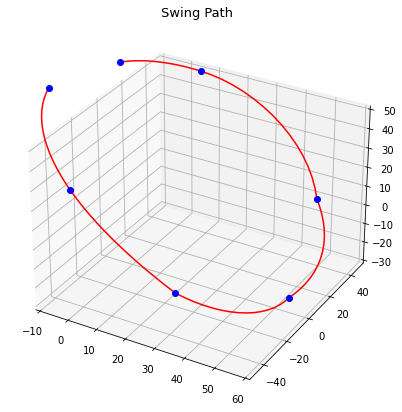

In [10]:
# Make points for the seven waypoints
x_end7 = np.zeros(len(S),)
y_end7 = np.zeros(len(S),)
z_end7 = np.zeros(len(S),)

for i in range(len(S)):
    
    anglesDesired = [S[i],L[i],U[i],R[i],B[i],T[i]]
    #Changing from normal physics conventions of angle definition to the way the robot defines them:
    anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                        (-np.pi/2+anglesDesired[2]),anglesDesired[3],anglesDesired[4],np.pi-anglesDesired[5]]
    
    End = Moto.findEnd(anglesConvention)
    x_end7[i],y_end7[i],z_end7[i] = End[0],End[1],End[2]
    

# creating an empty canvas
fig2 = plt.figure(figsize = (14,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax2 = plt.axes(projection="3d")
ax2.set_xlim(-10,60)
ax2.set_ylim(-50,50)
ax2.set_zlim(-30,50)

#ax_proj = fig2.add_subplot(1,2,2)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax2.plot3D(x_end,y_end,z_end, 'red')
ax2.plot3D(x_end7,y_end7,z_end7, 'bo')
#ax_proj.plot(y_end,z_end,'red')


 
# Showing the above plot
plt.title('Swing Path',fontsize=13)
plt.show()

In [18]:
def makeTime(x_end,y_end,z_end,max_vel):
    #Initalize Everything
    pts = len(x_end)
    time = 0
    t_array = np.array([0])
    vel = np.zeros(pts,)
    dist = np.zeros(pts-1,)
    
    #Make the velocity of the actual club a gauss curve
    for i in range(len(t_pts-1)):
        vel[i] = max_vel*np.exp(-(i-(pts/2))**2/(2*25**2))
        
    for i in range(pts-1):
        dist[i] = np.sqrt((x_end[i+1]-x_end[i])**2+(y_end[i+1]-y_end[i])**2+(z_end[i+1]-z_end[i])**2)
        time = time + dist[i]/vel[i];
        t_array = np.append(t_array,time)
        
    return t_array,vel,dist
   
    


[0.         0.03464103 0.06695596 0.09714666 0.12539358 0.15185834
 0.17668595 0.20000669 0.22193788 0.24258533 0.26204466 0.28040239
 0.297737   0.3141198  0.32961566 0.34330842 0.35921993 0.37439191
 0.38886915 0.40269294 0.41590133 0.4285295  0.44061006 0.45217322
 0.46324712 0.47385794 0.48403016 0.49378665 0.50314888 0.51213701
 0.52019865 0.52969429 0.53908208 0.54836813 0.55755838 0.56665857
 0.57567427 0.58461095 0.59347393 0.60226842 0.61099955 0.61967233
 0.62829169 0.63686244 0.64538933 0.65331212 0.66068226 0.66813467
 0.67567761 0.68331958 0.69106939 0.69893618 0.7069294  0.71505884
 0.72333467 0.73176743 0.74036809 0.74914804 0.75811913 0.7672937
 0.77605837 0.78819296 0.80070044 0.81358966 0.82686955 0.84054913
 0.85463746 0.86914374 0.88407733 0.89944792 0.9152656  0.93154117
 0.94828634 0.96551408 0.98323901 1.00027317 1.00950063 1.01912724
 1.02918465 1.03970728 1.05073259 1.06230141 1.07445832 1.08725199
 1.10073566 1.11496767 1.13001192 1.14593859 1.16282478 1.18075

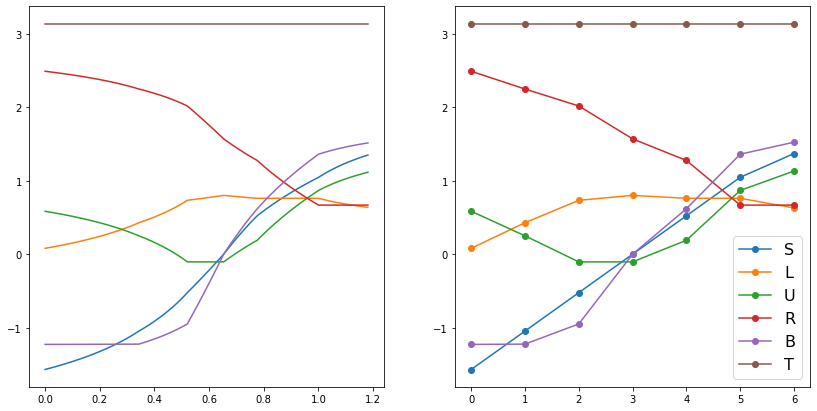

In [24]:
max_vel = 40*12 #in/sec
t_array,vel,dist = makeTime(x_end,y_end,z_end,max_vel)

print(t_array)
print(vel)



fig4 = plt.figure(figsize = (14,7))
ax4 = fig4.add_subplot(1,2,1)
ax5 = fig4.add_subplot(1,2,2)
ax4.plot(t_array,long_S,'-')
ax4.plot(t_array,long_L,'-')
ax4.plot(t_array,long_U,'-')
ax4.plot(t_array,long_R,'-')
ax4.plot(t_array,long_B,'-')
ax4.plot(t_array,long_T,'-')
ax5.plot(index,S,'-o')
ax5.plot(index,L,'-o')
ax5.plot(index,U,'-o')
ax5.plot(index,R,'-o')
ax5.plot(index,B,'-o')
ax5.plot(index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
plt.show()

In [25]:
#Find the joint velocities
vel_s = [0]
vel_l = [0]
vel_u = [0]
vel_r = [0]
vel_b = [0]
vel_t = [0]

for i in range(int(len(long_S)-1)):
    vel_s = np.append(vel_s,(long_S[i+1]-long_S[i])/(t_array[i+1]-t_array[i]))
    vel_l = np.append(vel_l,(long_L[i+1]-long_L[i])/(t_array[i+1]-t_array[i]))
    vel_u = np.append(vel_u,(long_U[i+1]-long_U[i])/(t_array[i+1]-t_array[i]))
    vel_r = np.append(vel_r,(long_R[i+1]-long_R[i])/(t_array[i+1]-t_array[i]))
    vel_b = np.append(vel_b,(long_B[i+1]-long_B[i])/(t_array[i+1]-t_array[i]))
    vel_t = np.append(vel_t,(long_T[i+1]-long_T[i])/(t_array[i+1]-t_array[i]))

print(vel_s)
print(vel_u)
print(vel_b)




[0.         1.01216456 1.08502198 1.161365   1.24128286 1.32487171
 1.41223545 1.50348646 1.59874645 1.69814721 1.8018315  1.90995391
 2.02268191 2.14019699 2.26269597 2.38994344 2.20358815 2.31099936
 2.4218981  2.53638331 2.65455682 2.77652254 2.90238552 3.03225086
 3.1662223  3.30440061 3.44688154 3.59375329 3.74509349 3.90096539
 4.05934182 3.69247274 3.73489919 3.77581441 3.8151758  3.85293445
 3.88903726 3.92342908 3.95605455 3.98685986 4.01579425 4.04281136
 4.06787028 4.09093644 4.11198224 4.13048231 4.75736129 4.70483805
 4.64837913 4.58813909 4.5242894  4.45701693 4.38652231 4.31301811
 4.23672692 4.15787929 4.07671166 3.9934643  3.90837925 3.82169834
 3.73372799 2.88946135 2.80331614 2.72029043 2.64026344 2.56312218
 2.48875585 2.41705112 2.34788825 2.28113801 2.21665924 2.15429717
 2.09388234 2.03523021 1.97814146 1.92113595 2.34837591 2.25100636
 2.1545867  2.05933012 1.96543799 1.87309929 1.78248997 1.69377254
 1.60709568 1.52259399 1.44038779 1.36058309 1.28327154 1.2085